In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random
from collections import OrderedDict

In [2]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [3]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
file2exercise = {"../alphapose_res/irimi_tenkan_kps.json":"ирими тенкан", 
                 "../alphapose_res/ta_tracking.json":"цуги аши",
                 "../alphapose_res/utmt_kps.json":"уширо тенкан мае тенкан"}
single_st_ann = "../data/single_student_annotations.json"

SEQ_LEN_FRAMES = 256
CHANNELS = 3
SEED = 42
BATCH_FIRST = False

# Подготовка данных

In [8]:
from dataproc import *
from train_utils import * 

In [9]:
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                            "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
student_exercise_points, exercise_borders = parse_borders_annotations(file2mapping, single_st_ann, 
                                                                      annotations_map, ss_vid_ann, 
                                                                      single_student_tids)
frame_durs = [stex.shape[1] for stex in student_exercise_points]
encoded_borders = encode_borders(exercise_borders, frame_durs, "<EXERCISE_BODY>")
split_exercs, split_borders = split_into_equal_frame_len(student_exercise_points, encoded_borders, SEQ_LEN_FRAMES, drop_last=False)

## Датасет

In [10]:
default_feature_flatten = lambda x: np.transpose(x, (1, 0, 2)).reshape(SEQ_LEN_FRAMES, -1)

class FrameTaggingDataset(Dataset):
    def __init__(self, inputs:list, tag_vec:list, channel_count:int, sequence_length:int, 
                 feature_flatten_fn=default_feature_flatten, batch_first:bool=False):
        self.inputs = inputs
        self.tag_vecs = tag_vec
        self.channels = channel_count
        self.batch_first = batch_first
        self.seq_len = sequence_length
        assert feature_flatten_fn != None
        self.feature_flatten = feature_flatten_fn
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        img = self.inputs[idx]
        img = img[:, :, :self.channels] 
        vectorized_seq = self.feature_flatten(img).astype('float32')
        if not self.batch_first:
            vectorized_seq = vectorized_seq.reshape(self.seq_len, 1, -1)
        return vectorized_seq, self.tag_vecs[idx].astype('float32')

In [11]:
# how to split to train/test/validation ?
random.seed(SEED)
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

train_ids, test_ids, val_ids = [], [], []
train_xs, train_tags = [], []
test_xs, test_tags = [], []
val_xs, val_tags = [], []

for s in split_exercs:
    for i, student_frames in enumerate(split_exercs[s]):
        rval = random.random()
        if rval <= train_frac:
            train_xs.append(student_frames)
            train_tags.append(split_borders[i])
            train_ids.append((s, i))
        elif rval <= (train_frac + test_frac):
            test_xs.append(student_frames)
            test_tags.append(split_borders[i])
            test_ids.append((s, i))
        else:
            val_xs.append(student_frames)
            val_tags.append(split_borders[i])
            val_ids.append((s, i))

total_data_count = len(train_xs) + len(test_xs) + len(val_xs)

print("Total", total_data_count)
print("Train count", len(train_xs))
print("Test count", len(test_xs))
print("Val count", len(val_xs))

Total 209
Train count 151
Test count 37
Val count 21


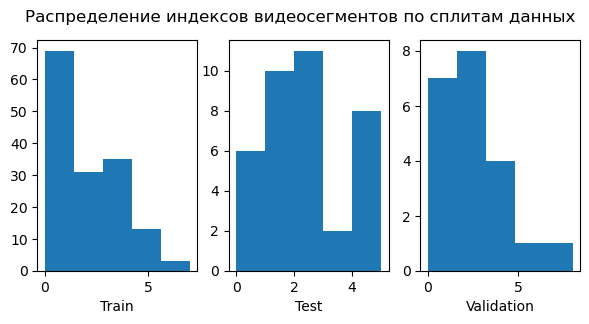

In [12]:
train_segment_idx = [f[-1] for f in train_ids]
test_segment_idx = [f[-1] for f in test_ids]
val_segment_idx = [f[-1] for f in val_ids]

train_hist_data = np.histogram(train_segment_idx, 5)
test_hist_data = np.histogram(test_segment_idx, 5)
val_segment_idx = np.histogram(val_segment_idx, 5)

fig, axs = plt.subplots(1, 3, figsize=(7, 3))
axs[0].stairs(train_hist_data[0], train_hist_data[1], fill=True)
axs[0].set_xlabel("Train")
axs[1].stairs(test_hist_data[0], test_hist_data[1], fill=True)
axs[1].set_xlabel("Test")
axs[2].stairs(val_segment_idx[0], val_segment_idx[1], fill=True)
axs[2].set_xlabel("Validation")
fig.suptitle('Распределение индексов видеосегментов по сплитам данных')
plt.show()

In [13]:
train_ds = FrameTaggingDataset(train_xs, train_tags, CHANNELS, SEQ_LEN_FRAMES, batch_first=BATCH_FIRST)
val_ds = FrameTaggingDataset(val_xs, val_tags, CHANNELS, SEQ_LEN_FRAMES, batch_first=BATCH_FIRST)
test_ds = FrameTaggingDataset(test_xs, test_tags, CHANNELS, SEQ_LEN_FRAMES, batch_first=BATCH_FIRST)

batch_size = 32
if BATCH_FIRST:
    collate_func = torch.utils.data.default_collate
else:
    collate_func = batch_second_collate
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_func)
val_loader = DataLoader(val_ds, 1, collate_fn=collate_func)
test_loader = DataLoader(test_ds, 1, shuffle=False, collate_fn=collate_func)

# Обучение

## Модель

In [21]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging
class FrameTaggerModel(torch.nn.Module):
    def __init__(self, input_dim:int, tagset_size:int, batch_first:bool, hidden_size:int=100, recurrent_layers:int=5):
        super(FrameTaggerModel, self).__init__()
        self.batch_first = batch_first
        self.recurrent = torch.nn.LSTM(input_dim, hidden_size, num_layers=recurrent_layers, batch_first=batch_first)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, tagset_size),
            torch.nn.LogSoftmax(1)
        )
        
    def forward(self, xb):
        if not self.batch_first or len(xb.shape)==2:
            seq_len = xb.shape[0]
        else:
            seq_len = xb.shape[1]
        lstm_out, _ = self.recurrent(xb)
        tag_scores = self.fc(lstm_out.view(seq_len, -1))
        return tag_scores

In [22]:
test_input = torch.rand(SEQ_LEN_FRAMES, 26 * CHANNELS)
tester = FrameTaggerModel(26 * CHANNELS, len(EXTOKENS), BATCH_FIRST, 10)
output = tester(test_input)
output.shape

torch.Size([256, 6])